# 3a) Training a GAN to generate 10 new items

**Using pytorch DCGAN example as a reference**

**Imports and setting up the manual seed:**

In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from torchvision.utils import make_grid

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [74]:
workers = 2 # Number of workers for dataloader
batch_size = 128

# Spatial size of training images. All images will be resized to this
image_size = 28
image_size_flat = 784 # 28 x 28
latent_space_size = 101 # this had to change from 100 to 101 because label is included in CGAN

num_epochs = 20
lr = 2e-4

**Loading the dataset:**

In [3]:
#directory for dataset
dataroot = '~/.pytorch/F_MNIST_data'
# Create the dataset
dataset = datasets.FashionMNIST(root=dataroot,
                           download=True,
                           train=True, 
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [4]:
real_batch = next(iter(dataloader))
np.shape(real_batch[0].to(device)[0])

torch.Size([1, 28, 28])

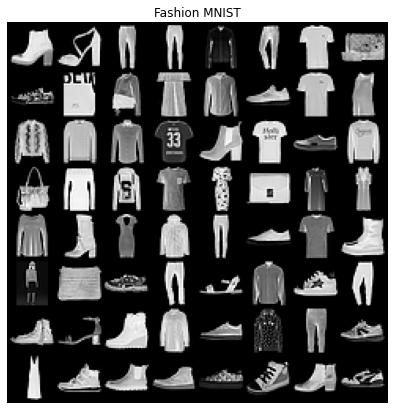

In [5]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(7,7))
plt.axis("off")
plt.title("Fashion MNIST")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [34]:
# Custom weights for modules' initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.2)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

**Defining models:**

In [75]:
# classes should change to one_hot vectors in order to be able to use them in nn.Linear
class Condition(nn.Module):
    def __init__(self, alpha=0.1):
        super().__init__()

        # From one-hot encoding to features: 10 => 784
        self.fc = nn.Sequential(
            nn.Linear(10, 784),
            nn.BatchNorm1d(784),
            nn.LeakyReLU(alpha))

    def forward(self, labels: torch.Tensor):
        # One-hot encode labels
        x = F.one_hot(labels, num_classes=10)

        # From Long to Float
        x = x.float()

        # To feature vectors
        return self.fc(x)

In [76]:
# Reshape helper
class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()

        self.shape = shape

    def forward(self, x):
        return x.reshape(-1, *self.shape)

In [78]:
# Generator Model
# transpose2d output size: (W-1)*S - 2p + K
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.reshape = Reshape(16,7,7)
        # sample_size => 784
        self.fc = nn.Sequential(
            nn.Linear(101, 784),
            nn.BatchNorm1d(784),
            nn.ReLU(True))

        # 28*28 = 784 => 16 x 7 x 7 => 32 x 14 x 14 => 1 x 28 x 28
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
            )
        self.cond = Condition()


    def forward(self, batch_size: int, labels):
        # Generate random noise as an input
        c = self.cond(labels)
        bs = len(labels)
        noise = torch.randn(bs, latent_space_size).to(device)

        # Use transposed convolutions for generator since we go from flat to image size
        x = self.fc(noise)
        #x = x.reshape(-1,16,7,7)
        x = self.reshape(x+c)
        x = self.conv(x)
        return x

In [79]:
# Create the generator
modelG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda'):
    modelG = nn.DataParallel(modelG, list(range(1)))

# Apply the weights_init function to randomly initialize all weights
modelG.apply(weights_init)

# Print the model
print(modelG)

DataParallel(
  (module): Generator(
    (reshape): Reshape()
    (fc): Sequential(
      (0): Linear(in_features=101, out_features=784, bias=True)
      (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv): Sequential(
      (0): ConvTranspose2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (4): Tanh()
    )
    (cond): Condition(
      (fc): Sequential(
        (0): Linear(in_features=10, out_features=784, bias=True)
        (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
  )
)


In [80]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cond = nn.Sequential(
            Condition(),
            Reshape(16,7,7)
        )
        # 1 x 28 x 28 => 32 x 14 x 14 
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # 32 x 14 x 14 => 16 x 7 x 7 => 784 = 1 x 28 x 28
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 784),
            nn.BatchNorm1d(784),
            nn.Sigmoid(),
            nn.Linear(784, 1),
            nn.Sigmoid(),
            )

    def forward(self, images: torch.Tensor, targets: torch.Tensor, labels):

        c = self.cond(labels)
        x = self.conv1(images)
        x = self.conv2(x)
        prediction = self.fc(x+c)

        #loss = F.binary_cross_entropy_with_logits(prediction, targets)
        return prediction

In [81]:
# Create the Discriminator
modelD = Discriminator()

# Handle multi-gpu if desired
if (device.type == 'cuda'):
    modelD = nn.DataParallel(modelD, list(range(1)))

# Apply the weights_init function to randomly initialize all weights
modelD.apply(weights_init)

# Print the model
print(modelD)

DataParallel(
  (module): Discriminator(
    (cond): Sequential(
      (0): Condition(
        (fc): Sequential(
          (0): Linear(in_features=10, out_features=784, bias=True)
          (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
      )
      (1): Reshape()
    )
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (fc): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=784, bias=True)
      (2): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True

**Optimizers for both generator and discriminator:**

In [82]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(params=modelD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(params=modelG.parameters(), lr=lr, betas=(0.5, 0.999))

**Training the DCGAN...**

In [83]:

# Real and fake labels
real_targets = torch.ones(batch_size, 1, dtype=torch.float, device=device)
fake_targets = torch.zeros(batch_size, 1, dtype=torch.float, device=device )


# Training loop

for epoch in range(num_epochs):

    d_losses, g_losses = [],[]

    for images, labels in tqdm(dataloader):
        #print(images.shape, labels.shape)
        ############################
        # Discriminator training
        # maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        modelD.zero_grad()
        # forward pass the real batch through discriminator
        realD = modelD(images.to(device), real_targets, labels)
        lossD_real = criterion(realD,real_targets)
        # calculate gradients
        lossD_real.backward()

        # now generate batch of latent vectors
        fake = modelG(batch_size, labels).to(device)
        # classify fake generated images with discriminator now
        # and pass the loss
        fakeD = modelD(fake.detach(), fake_targets, labels)
        lossD_fake = criterion(fakeD,fake_targets)
        #calculate gradients for fake ones now
        lossD_fake.backward()
        # complete error of discriminator over fake and real images
        errorD = lossD_real + lossD_fake

        optimizerD.step()

        ############################
        # Generator Network Training
        # maximize log(D(G(z)))
        ###########################

        modelG.zero_grad()
        # pass fake images to discriminator and calculate the loss
        realG = modelD(fake.to(device), real_targets, labels)
        lossG_real = criterion(realG,real_targets)
        # calculate gradients
        lossG_real.backward()
        
        optimizerG.step()

        # Keep losses for logging
        d_losses.append(errorD.item())
        g_losses.append(lossG_real.item())


    # Print average losses for both generator and discriminator
    print()
    print(f" epoch {epoch}, Discriminator Loss: {np.mean(d_losses)}, Generator Loss: {np.mean(g_losses)}")
    print()


100%|██████████| 468/468 [00:17<00:00, 26.71it/s]



 epoch 0, Discriminator Loss: 0.7176284337273011, Generator Loss: 1.3015176475557506



100%|██████████| 468/468 [00:17<00:00, 26.65it/s]



 epoch 1, Discriminator Loss: 0.6364124703865784, Generator Loss: 1.5219101694404569



100%|██████████| 468/468 [00:17<00:00, 26.43it/s]



 epoch 2, Discriminator Loss: 0.6256515028385016, Generator Loss: 1.5558220229597173



100%|██████████| 468/468 [00:17<00:00, 26.69it/s]



 epoch 3, Discriminator Loss: 0.5182198836890042, Generator Loss: 1.7993190502509093



100%|██████████| 468/468 [00:17<00:00, 26.56it/s]



 epoch 4, Discriminator Loss: 0.48559457942461354, Generator Loss: 1.9580335186587439



100%|██████████| 468/468 [00:17<00:00, 26.24it/s]



 epoch 5, Discriminator Loss: 0.45145235032352626, Generator Loss: 2.073679841736443



100%|██████████| 468/468 [00:17<00:00, 26.68it/s]



 epoch 6, Discriminator Loss: 0.42344089177174443, Generator Loss: 2.2173068332366452



100%|██████████| 468/468 [00:17<00:00, 26.24it/s]



 epoch 7, Discriminator Loss: 0.39914471299475074, Generator Loss: 2.3339393607571592



100%|██████████| 468/468 [00:17<00:00, 26.13it/s]



 epoch 8, Discriminator Loss: 0.38203731160133314, Generator Loss: 2.43465663276167



100%|██████████| 468/468 [00:17<00:00, 26.24it/s]



 epoch 9, Discriminator Loss: 0.3571744323349916, Generator Loss: 2.5300478476744432



100%|██████████| 468/468 [00:17<00:00, 26.67it/s]



 epoch 10, Discriminator Loss: 0.3512982781817261, Generator Loss: 2.596273616847829



100%|██████████| 468/468 [00:17<00:00, 26.74it/s]



 epoch 11, Discriminator Loss: 0.3338398539230355, Generator Loss: 2.6759162906907563



100%|██████████| 468/468 [00:17<00:00, 26.57it/s]



 epoch 12, Discriminator Loss: 0.3190196809860376, Generator Loss: 2.752519559656453



100%|██████████| 468/468 [00:17<00:00, 26.68it/s]



 epoch 13, Discriminator Loss: 0.3103704721563392, Generator Loss: 2.8183386356402664



100%|██████████| 468/468 [00:17<00:00, 26.41it/s]



 epoch 14, Discriminator Loss: 0.30610012205747456, Generator Loss: 2.859184643142244



100%|██████████| 468/468 [00:17<00:00, 26.74it/s]



 epoch 15, Discriminator Loss: 0.30467192717214936, Generator Loss: 2.915633914817093



100%|██████████| 468/468 [00:17<00:00, 26.43it/s]



 epoch 16, Discriminator Loss: 0.2997846113056199, Generator Loss: 2.91883503117113



100%|██████████| 468/468 [00:17<00:00, 26.92it/s]



 epoch 17, Discriminator Loss: 0.29760104252232444, Generator Loss: 2.934558446590717



100%|██████████| 468/468 [00:17<00:00, 26.68it/s]



 epoch 18, Discriminator Loss: 0.29126475127334267, Generator Loss: 2.9606227146254644



100%|██████████| 468/468 [00:17<00:00, 26.98it/s]


 epoch 19, Discriminator Loss: 0.29106882482002944, Generator Loss: 2.9753608321532226



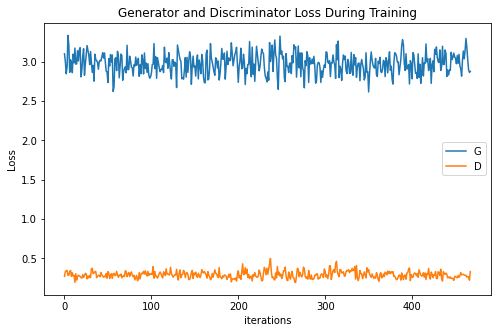

In [84]:
plt.figure(figsize=(8,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate new samples with DCGAN:

In [85]:
test = next(iter(dataloader))
test[1].shape

torch.Size([128])

tensor([8, 9, 2, 0, 4, 5, 6, 4, 1, 1, 1, 1, 5, 7, 9, 4, 4, 9, 3, 9, 7, 6, 4, 6,
        1, 8, 3, 3, 0, 5, 8, 6, 8, 7, 3, 2, 8, 4, 1, 1, 6, 4, 5, 0, 9, 1, 9, 8,
        6, 5, 3, 4, 2, 4, 4, 7, 9, 7, 7, 5, 9, 1, 6, 0, 0, 8, 4, 8, 1, 5, 7, 8,
        6, 0, 5, 4, 7, 5, 6, 1, 4, 3, 5, 3, 6, 1, 8, 8, 2, 1, 0, 8, 6, 9, 8, 8,
        1, 5, 0, 0, 3, 3, 6, 4, 0, 5, 1, 3, 2, 8, 6, 7, 0, 9, 4, 9, 1, 1, 1, 7,
        5, 6, 2, 6, 8, 8, 8, 6])


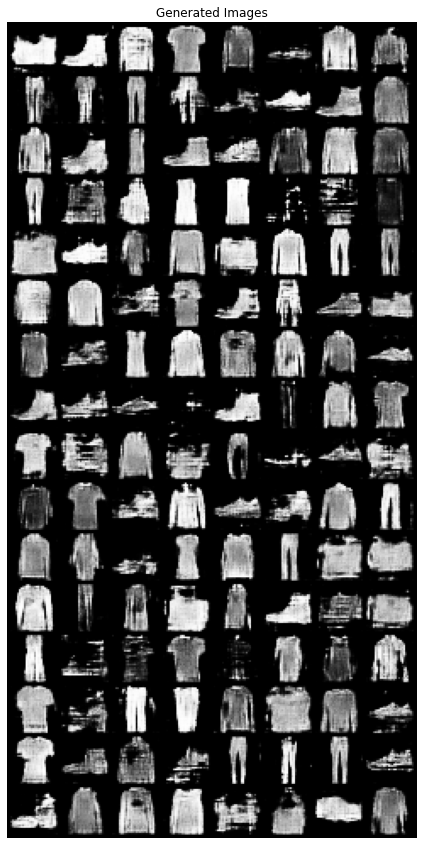

In [86]:
# Plot some generated images
classes_test = torch.randint(10, (128,))
print(classes_test)
DCGAN_image = modelG(batch_size, classes_test).detach()
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(DCGAN_image.to(device)[:], padding=2, normalize=True).cpu(),(1,2,0)))

***Visually the results of conditional DCGAN by including labels in generator and discriminator with same number of epochs and hyperparameters looks slightly better!  ***